In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install -U tensorflow-addons

In [ ]:
!pwd

/content


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
from sklearn.model_selection import train_test_split
num_classes = 10
np.random.seed(0)
import pandas as pd
from sklearn.utils import shuffle
x_train = pd.read_csv('/content/gdrive/MyDrive/COSI/Video processing and Advanced project/ferattention-master/emoji_10_Emotion_COSI.csv')
y_train = x_train['emotion']
x_train.drop(['emotion'], inplace = True, axis = 1 )
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25)



In [ ]:
x_train = X_train.values
y_train = y_train.values
x_test = X_test.values
y_test = y_test.values

In [ ]:
x_train = x_train.reshape(-1,48,48,1)
x_test = x_test.reshape(-1,48,48,1)

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (9825, 48, 48, 1) - y_train shape: (9825,)
x_test shape: (3275, 48, 48, 1) - y_test shape: (3275,)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 60
image_size = 48  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.1, width_factor=0.1
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=(48,48,1))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
cd '/content/gdrive/MyDrive/COSI/Video processing and Advanced project/ferattention-master/model H5 and Json'

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/COSI/Video processing and Advanced project/ferattention-master/model H5 and Json'
/content


In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/gdrive/MyDrive/COSI/Video processing and Advanced project/ferattention-master/Emotion_Classes.zip (Unzipped Files)"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/60
246/246 [==============================] - 58s 180ms/step - loss: 2.8397 - accuracy: 0.1412 - top-5-accuracy: 0.5832 - val_loss: 2.1546 - val_accuracy: 0.2499 - val_top-5-accuracy: 0.7064
Epoch 2/60
246/246 [==============================] - 43s 175ms/step - loss: 2.1757 - accuracy: 0.2209 - top-5-accuracy: 0.6941 - val_loss: 1.9676 - val_accuracy: 0.3145 - val_top-5-accuracy: 0.8010
Epoch 3/60
246/246 [==============================] - 46s 186ms/step - loss: 2.0484 - accuracy: 0.2734 - top-5-accuracy: 0.7424 - val_loss: 1.7859 - val_accuracy: 0.4051 - val_top-5-accuracy: 0.8407
Epoch 4/60
246/246 [==============================] - 45s 182ms/step - loss: 1.9389 - accuracy: 0.3230 - top-5-accuracy: 0.7836 - val_loss: 1.6690 - val_accuracy: 0.4280 - val_top-5-accuracy: 0.8768
Epoch 5/60
246/246 [==============================] - 46s 187ms/step - loss: 1.8451 - accuracy: 0.3394 - top-5-accuracy: 0.8150 - val_loss: 1.6271 - val_accuracy: 0.4417 - val_top-5-accuracy: 0.8931
Epoch

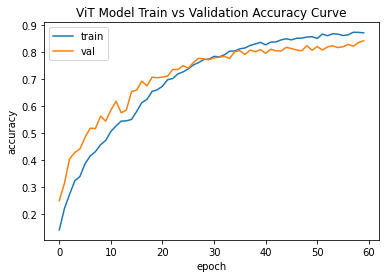

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ViT Model Train vs Validation Accuracy Curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

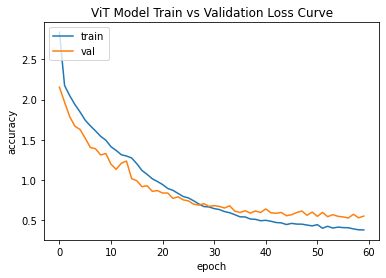

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ViT Model Train vs Validation Loss Curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
np.set_printoptions(precision=2)
class_names = ['angry', 'disgust', 'fear','happy', 'mockery', 'neutral','sad', 'surprise', 'think', 'wink']

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  
from sklearn.metrics import ConfusionMatrixDisplay
Y_pred = vit_classifier.predict_generator(x_test)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(X = y_pred, y_true=y_test, labels = class_names, normalize=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


Normalized confusion matrix


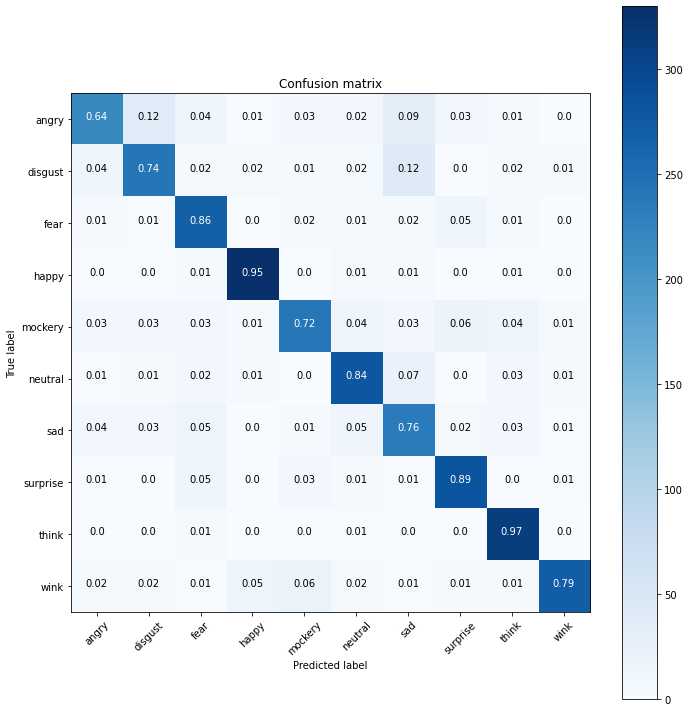

In [ ]:
import matplotlib.pyplot as plt
import itertools 
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, class_names)